<a href="https://colab.research.google.com/github/swilsonmfc/stable-diffusion/blob/main/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DDPM - Denoising Diffusion Probablistic Models

![](https://blog.kakaocdn.net/dn/CcdZc/btreCUmqJJa/1MRak79KeYxsTUYAY1KdH1/img.png)

# Install

In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.5 MB/s eta 0:00:00


# Setup

In [2]:
import random
import imageio
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

# Intuition
* Paper - https://arxiv.org/abs/2006.11239
* Diffusion - Learn the reverse of noise generation
  * X0 = Original Image
  * $X_T$ = Noise
  * $X_t$ = Original Image + Noise @ timestep t
  * q$\theta$ = Forward process
  * p$\theta$ = Reverse process


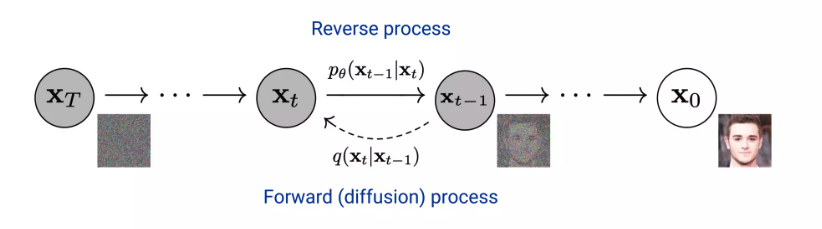

## Incrementally Adding Noise (Forward)
* Noise is gaussian
* Adding more gaussian noise is also gaussian
* Products of adding noise can be thought of as markovian
* Normal
  * $\beta$ - Diffusion coefficient - Noise based on a schedule
  * Sample from N(0, I) - Zero mean & Identity



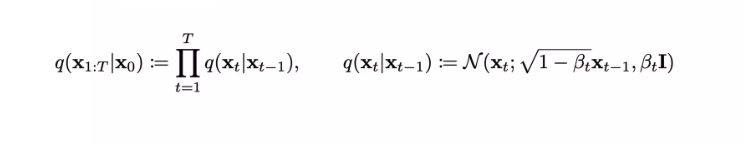

## Removing Noise (Reverse)
* We don't know p($x_{t-1}$ | $x_t$) -- too many possible images
* Learn the conditional probability
  * Mean parameterized by $\mu_\theta$
  * Variance parameterized by $\Sigma_\theta$
* Where mean and variance are also conditioned on noise level t
* In DDPM, we keep the variance fixed, learning only $\mu_\theta$

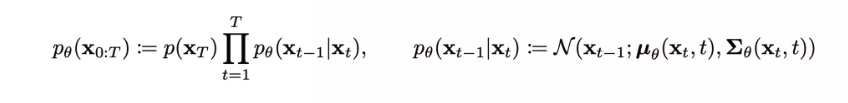

## Reparameterize
* Consider the residual in the denoiser
* Most of the information is redundant
* Sum of gaussians is gaussian

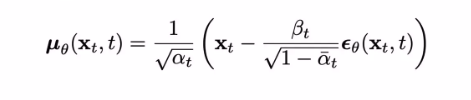

## Training
* Take random sample $x_0$ from q($x_0$)
* Sample noise level $t$ uniformly between 1 and T (picking a random time step)
* Sample noise from a Gaussian at this level $t$
* Corrupt the input by this noise at level $t$
* Train the net to predict noise based on $x_t$ (the noise applied on $x_0$ based on the noise schedule $\beta_t$

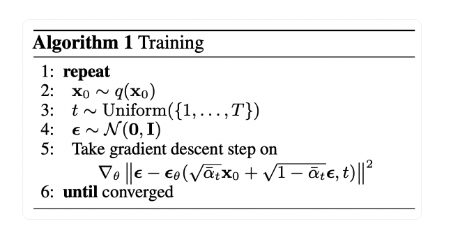

## Limitations
* Slow (iterative) over many steps
* Pixel space (UNets)

## DDPM - Noise
* A noise schedule defines the sequence of noise to be added during training
* Start with a small amount of noise and increase it over multiple steps

In [3]:
# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

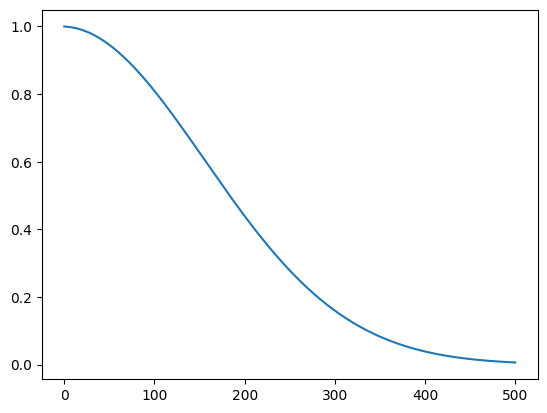

In [4]:
plt.plot(ab_t.numpy())

## DDIM
* Denoising Diffusion Implicit Models
* Skips Timesteps
* Breaks Markov Assumption
* DDIM (< 500 Steps) DDPM (> 500 Steps)

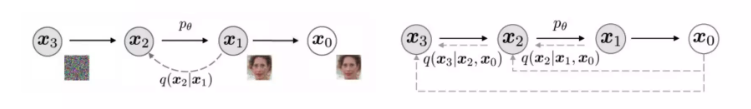

# Device - GPU / CPU

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
DEVICE

device(type='cuda', index=0)

# Parameters

In [6]:
NO_TRAIN   = False
BATCH_SIZE = 128
EPOCHS     = 20
LR         = 0.001

# Loader

In [7]:
# prompt: load MNIST and create a data loader with a transforms to normalize between -1 and 1

from torchvision import datasets, transforms

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 345729585.00it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 22907657.68it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 131221375.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3643245.13it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
# prompt: create a show_images function that takes in a list of images and plots then in a square

def show_images(images, caption):
  if type(images) is torch.Tensor:
    images = images.detach().cpu().numpy()

  num_images = min(len(images), 64)

  cols = 8
  rows = int(np.ceil(num_images / cols))

  fig, axs = plt.subplots(rows, cols)
  for i in range(rows * cols):
    img = np.squeeze(images[i])
    axs[i//cols, i%cols].imshow(img)
    axs[i//cols, i%cols].axis("off")
  fig.suptitle(caption)

  for ax in axs.flat:
    ax.set_aspect('auto')
  fig.tight_layout()

  plt.show()

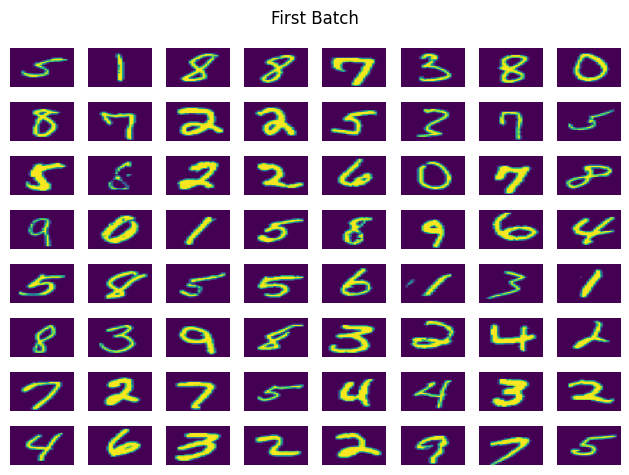

In [9]:
# prompt: create a function to take the first batch from loader and call show images

def show_batch(loader):
  images, labels = next(iter(loader))
  show_images(images, 'First Batch')
show_batch(loader)

# Model Classes

## Embedding

In [10]:
# prompt: create a function named sinusoidal_embedding
#         that performs the same on n number of steps and d dimensionality

def sinusoidal_embedding(n, d):
  """
  Creates a sinusoidal embedding matrix of size (n, d).

  Args:
    n: The number of steps.
    d: The dimensionality of the embedding.

  Returns:
    Embedding matrix of size (n, d).
  """

  emb = np.zeros((n, d))
  indices = np.arange(0, n)[:, None]
  frequencies = np.exp(np.arange(0, d, 2) * -np.log(10000) / d)
  emb[:, 0::2] = np.sin(indices * frequencies)
  emb[:, 1::2] = np.cos(indices * frequencies)
  return emb


In [11]:
sinusoidal_embedding(4, 4)

array([[ 0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.84147098,  0.54030231,  0.00999983,  0.99995   ],
       [ 0.90929743, -0.41614684,  0.01999867,  0.99980001],
       [ 0.14112001, -0.9899925 ,  0.0299955 ,  0.99955003]])

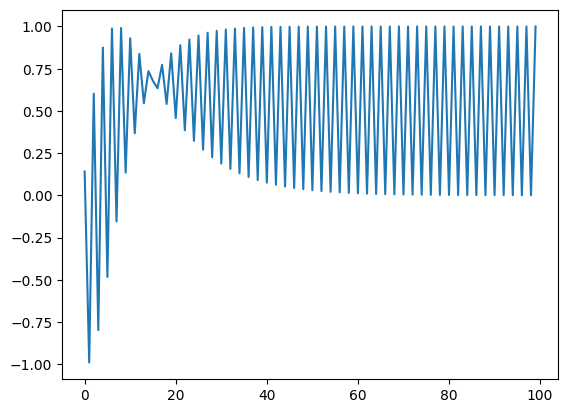

In [12]:
emb = sinusoidal_embedding(1000, 100)
#for e in emb:
  #plt.plot(np.arange(0, len(e)), e)
plt.plot(emb[3])

## Block

In [13]:
class Block(nn.Module):
  def __init__(self, shape, in_c, out_c,
                kernel_size=3, stride=1, padding=1,
                activation=None, normalize=True):
    super(Block, self).__init__()
    self.ln = nn.LayerNorm(shape)
    self.conv1 = nn.Conv2d(in_c,  out_c, kernel_size, stride, padding)
    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
    self.activation = nn.SiLU() if activation is None else activation
    self.normalize = normalize

  def forward(self, x):
    out = self.ln(x) if self.normalize else x
    out = self.conv1(out)
    out = self.activation(out)
    out = self.conv2(out)
    out = self.activation(out)
    return out

## UNet

In [14]:
def sinusoidal_embedding(n, d):
  embedding = torch.zeros(n, d)
  wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
  wk = wk.reshape((1, d))
  t = torch.arange(n).reshape((n, 1))
  embedding[:,::2]  = torch.sin(t * wk[:,::2])
  embedding[:,1::2] = torch.cos(t * wk[:,::2])
  return embedding

In [15]:
class UNet(nn.Module):
  def __init__(self, n_steps=1000, time_emb_dim=100):
    super(UNet, self).__init__()

    # Sinusoidal embedding
    self.time_embed = nn.Embedding(n_steps, time_emb_dim)
    self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
    self.time_embed.requires_grad_(False)

    # First half
    self.te1 = self._make_te(time_emb_dim, 1)
    self.b1 = nn.Sequential(
        Block((1, 28, 28), 1, 10),
        Block((10, 28, 28), 10, 10),
        Block((10, 28, 28), 10, 10)
    )
    self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

    self.te2 = self._make_te(time_emb_dim, 10)
    self.b2 = nn.Sequential(
        Block((10, 14, 14), 10, 20),
        Block((20, 14, 14), 20, 20),
        Block((20, 14, 14), 20, 20)
    )
    self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

    self.te3 = self._make_te(time_emb_dim, 20)
    self.b3 = nn.Sequential(
        Block((20, 7, 7), 20, 40),
        Block((40, 7, 7), 40, 40),
        Block((40, 7, 7), 40, 40)
    )
    self.down3 = nn.Sequential(
        nn.Conv2d(40, 40, 2, 1),
        nn.SiLU(),
        nn.Conv2d(40, 40, 4, 2, 1)
    )

    # Bottleneck
    self.te_mid = self._make_te(time_emb_dim, 40)
    self.b_mid = nn.Sequential(
        Block((40, 3, 3), 40, 20),
        Block((20, 3, 3), 20, 20),
        Block((20, 3, 3), 20, 40)
    )

    # Second half
    self.up1 = nn.Sequential(
        nn.ConvTranspose2d(40, 40, 4, 2, 1),
        nn.SiLU(),
        nn.ConvTranspose2d(40, 40, 2, 1)
    )

    self.te4 = self._make_te(time_emb_dim, 80)
    self.b4 = nn.Sequential(
        Block((80, 7, 7), 80, 40),
        Block((40, 7, 7), 40, 20),
        Block((20, 7, 7), 20, 20)
    )

    self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
    self.te5 = self._make_te(time_emb_dim, 40)
    self.b5 = nn.Sequential(
        Block((40, 14, 14), 40, 20),
        Block((20, 14, 14), 20, 10),
        Block((10, 14, 14), 10, 10)
    )

    self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
    self.te_out = self._make_te(time_emb_dim, 20)
    self.b_out = nn.Sequential(
        Block((20, 28, 28), 20, 10),
        Block((10, 28, 28), 10, 10),
        Block((10, 28, 28), 10, 10, normalize=False)
    )

    self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

  def forward(self, x, t):
    # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
    t = self.time_embed(t)
    n = len(x)
    out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
    out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
    out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

    out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

    out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
    out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

    out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
    out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

    out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
    out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

    out = self.conv_out(out)

    return out

  def _make_te(self, dim_in, dim_out):
    return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.SiLU(),
        nn.Linear(dim_out, dim_out)
    )

## DDPM
* Learn to reverse noise generation?


In [16]:
class DDPM(nn.Module):
  def __init__(self, network, n_steps=200, min_beta=10 ** -4,
                max_beta=0.02, device=DEVICE, image_chw=(1, 28, 28)):
    super(DDPM, self).__init__()
    self.n_steps = n_steps
    self.device = device
    self.image_chw = image_chw
    self.network = network.to(device)
    self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)  # Number of steps is typically in the order of thousands
    self.alphas = 1 - self.betas
    self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

  def forward(self, x0, t, eta=None):
    # Directly skip to the desired step for noise
    n, c, h, w = x0.shape
    a_bar = self.alpha_bars[t]

    if eta is None:
      eta = torch.randn(n, c, h, w).to(self.device)

    noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
    return noisy

  def backward(self, x, t):
    # Run each image and return the estimation of the noise that was added.
    return self.network(x, t)

# Model
* Model for DDPM includes the UNet

In [17]:
model = DDPM(UNet())

## Visualize

In [18]:
def show_forward(ddpm, loader, device=DEVICE):
  # Showing the forward process
  for batch in loader:
    imgs = batch[0]
    show_images(imgs, 'Original')

    for percent in [0.25, 0.5, 0.75, 1]:
      show_images(
        ddpm(imgs.to(device), [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
        f'Noise {int(percent * 100)}%')
    break


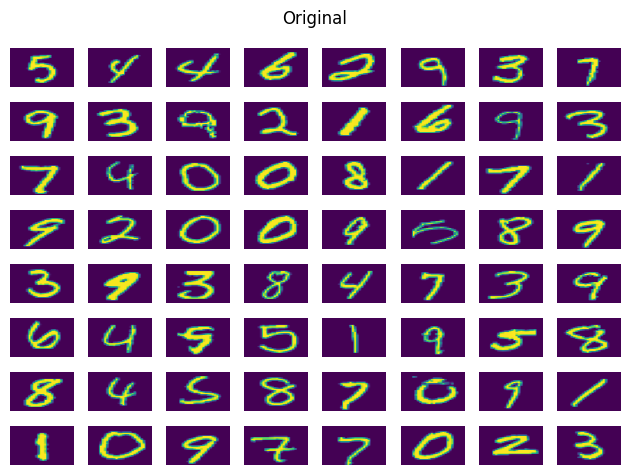

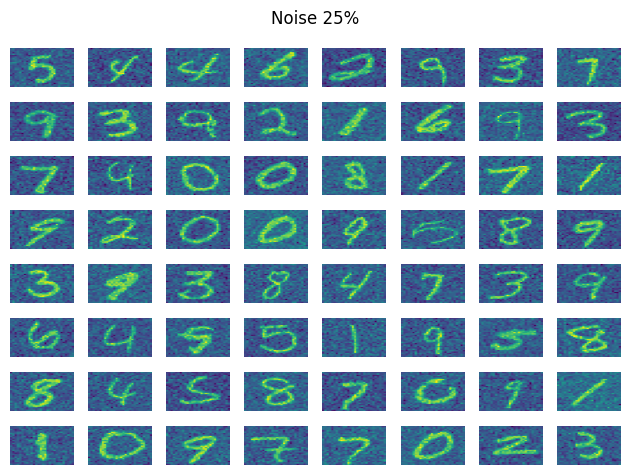

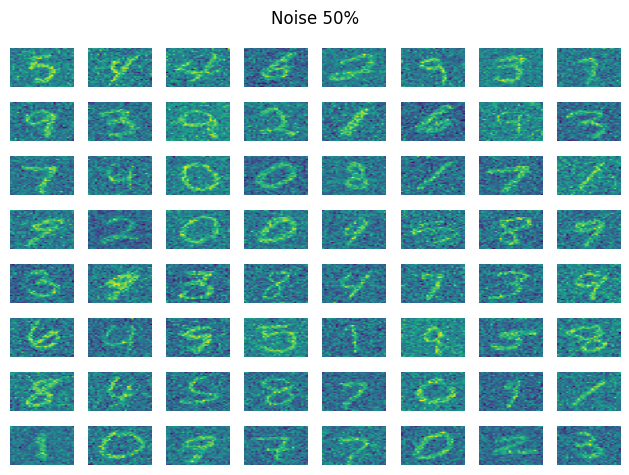

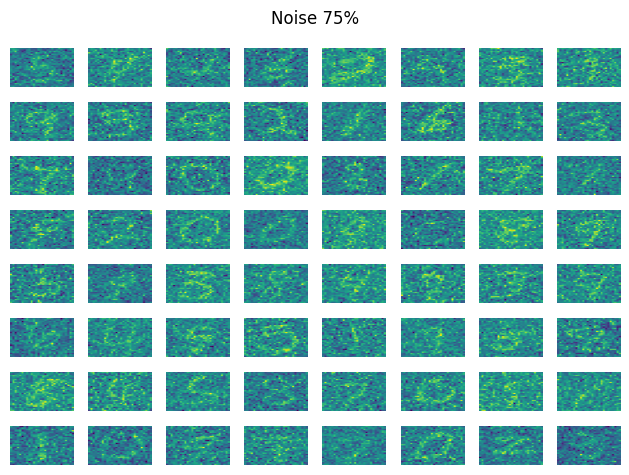

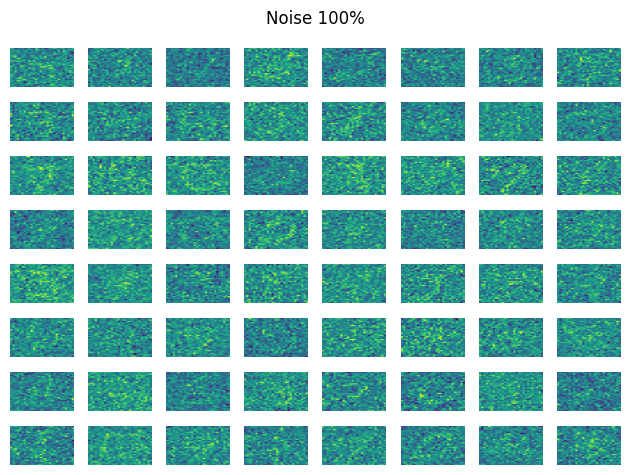

In [19]:
show_forward(model, loader)

# Train
![](https://i.imgur.com/S7KH5hZ.png)

In [24]:
def training_loop(ddpm, loader, n_epochs, optim, device=DEVICE,
                  display=False, store_path='ddpm_model.pt'):
  mse = nn.MSELoss()
  best_loss = float('inf')
  n_steps = ddpm.n_steps

  for epoch in tqdm(range(n_epochs), desc=f'Training progress', colour='#00ff00'):
    epoch_loss = 0.0
    for step, batch in enumerate(tqdm(loader, leave=False, desc=f'Epoch {epoch + 1}/{n_epochs}', colour='#005500')):
      # Loading data
      x0 = batch[0].to(device)
      n = len(x0)

      # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
      eta = torch.randn_like(x0).to(device)
      t = torch.randint(0, n_steps, (n,)).to(device)

      # Computing the noisy image based on x0 and the time-step (forward process)
      noisy_imgs = ddpm(x0, t, eta)

      # Getting model estimation of noise based on the images and the time-step
      eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

      # Optimizing the MSE between the noise plugged and the predicted noise
      loss = mse(eta_theta, eta)
      optim.zero_grad()
      loss.backward()
      optim.step()

      epoch_loss += loss.item() * len(x0) / len(loader.dataset)

    # Display images generated at this epoch
    if display:
      show_images(generate_new_images(ddpm, device=device), f'Images generated at epoch {epoch + 1}')
    log = f'Epoch {epoch + 1} Loss {epoch_loss:.3f}'

    # Store the model
    if best_loss > epoch_loss:
      best_loss = epoch_loss
      torch.save(ddpm.state_dict(), store_path)
      log += f' --> Best {best_loss:.3f}'
    print(log)

In [25]:
optim = Adam(model.parameters(), lr=LR)
training_loop(model, loader, EPOCHS, optim)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 Loss 0.072 --> Best 0.072


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 Loss 0.064 --> Best 0.064


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 Loss 0.062 --> Best 0.062


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 Loss 0.062 --> Best 0.062


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 Loss 0.061 --> Best 0.061


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 Loss 0.060 --> Best 0.060


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 Loss 0.059 --> Best 0.059


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 Loss 0.059 --> Best 0.059


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 Loss 0.058 --> Best 0.058


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 Loss 0.058 --> Best 0.058


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11 Loss 0.057 --> Best 0.057


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12 Loss 0.057 --> Best 0.057


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13 Loss 0.056 --> Best 0.056


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14 Loss 0.056 --> Best 0.056


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15 Loss 0.056 --> Best 0.056


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16 Loss 0.056 --> Best 0.056


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17 Loss 0.056 --> Best 0.056


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18 Loss 0.055 --> Best 0.055


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19 Loss 0.055


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20 Loss 0.054 --> Best 0.054


# Draw

In [95]:
def generate_image(ddpm, noise, device=DEVICE, c=1, h=28, w=28, plot_noise=True):
  """
  Given a DDPM model, a number of samples to be generated and a device
  Returns a generated sample
  """
  with torch.no_grad():
    if device is None:
      device = ddpm.device

    # Starting from random noise
    x = noise.clone()

    for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
      # Estimating noise to be removed
      time_tensor = (torch.ones(1, 1) * t).to(device).long()
      eta_theta = ddpm.backward(x, time_tensor)

      alpha_t = ddpm.alphas[t]
      alpha_t_bar = ddpm.alpha_bars[t]

      # Partially denoising the image
      x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

      if t > 0:
        z = torch.randn(1, c, h, w).to(device)
        beta_t = ddpm.betas[t]
        sigma_t = beta_t.sqrt()
        x = x + sigma_t * z

    x = x.detach().cpu().numpy() if type(x) is torch.Tensor else x
    noise = noise.detach().cpu().numpy() if type(noise) is torch.Tensor else noise

    img_x = np.squeeze(x)
    img_noise = np.squeeze(noise)

    if plot_noise:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(img_noise)
      ax[1].imshow(img_x)
      plt.show()
    else:
      plt.imshow(img_x)
      plt.show()


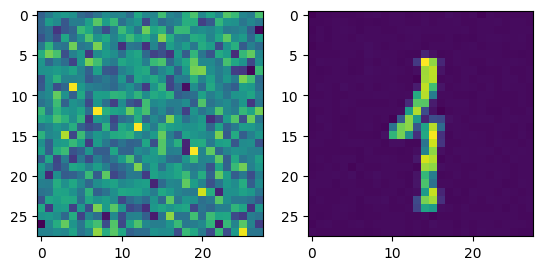

In [96]:
noise = torch.randn(1, 1, 28, 28).to(DEVICE)
generate_image(model, noise)

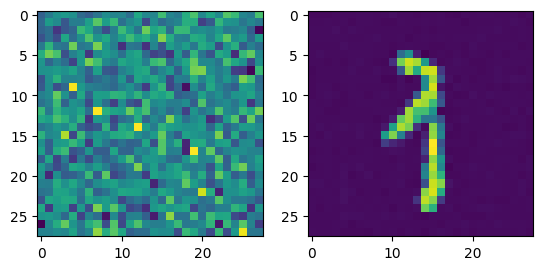

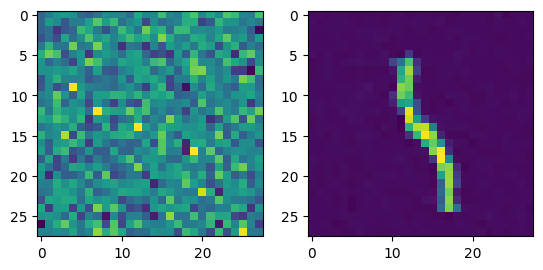

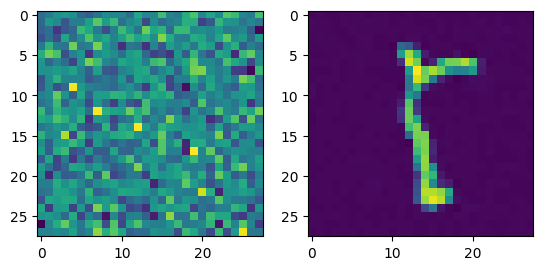

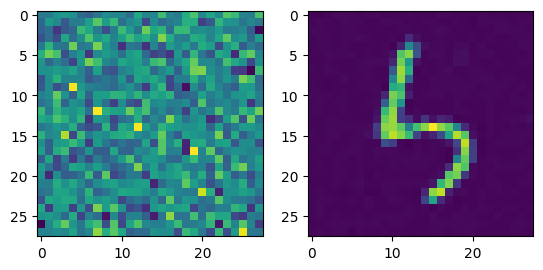

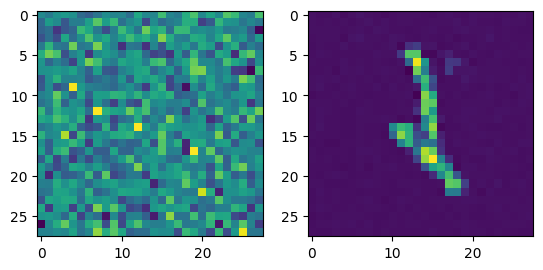

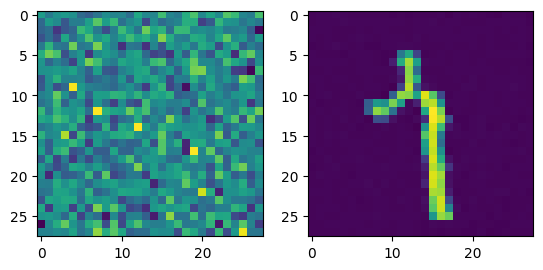

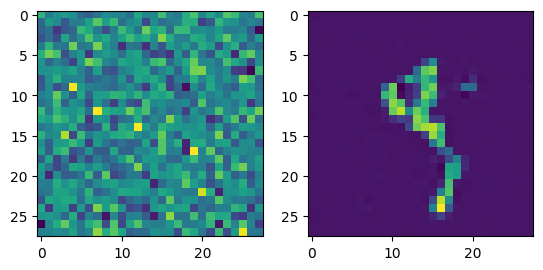

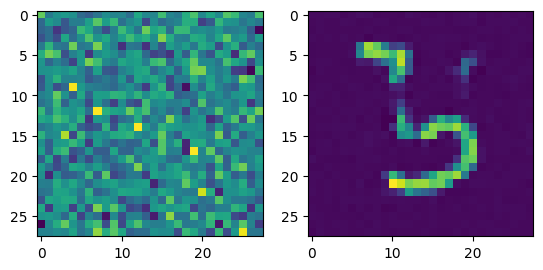

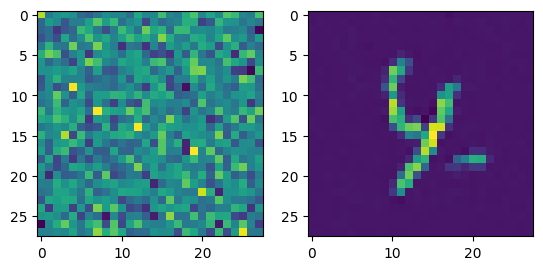

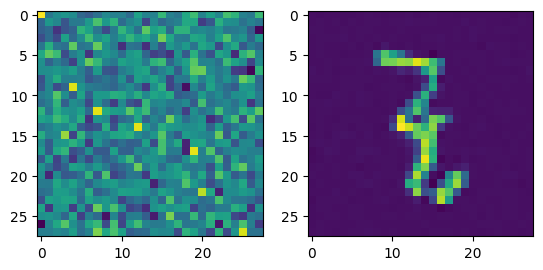

In [97]:
original = noise[0][0][0][0]
for adj in np.arange(0.0, 1., 0.1):
  noise[0][0][0][0] = original + adj
  generate_image(model, noise)

# Generate

In [79]:
def generate_new_images(ddpm, n_samples=16, device=DEVICE,
                        frames_per_gif=100, gif_name="sampling.gif",
                        c=1, h=28, w=28):
  """
  Given a DDPM model, a number of samples to be generated and a device
  Returns some newly generated samples
  """
  frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
  frames = []

  with torch.no_grad():
    if device is None:
      device = ddpm.device

    # Starting from random noise
    x = torch.randn(n_samples, c, h, w).to(device)

    for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
      # Estimating noise to be removed
      time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
      eta_theta = ddpm.backward(x, time_tensor)

      alpha_t = ddpm.alphas[t]
      alpha_t_bar = ddpm.alpha_bars[t]

      # Partially denoising the image
      x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

      if t > 0:
        z = torch.randn(n_samples, c, h, w).to(device)

        # Option 1: sigma_t squared = beta_t
        beta_t = ddpm.betas[t]
        sigma_t = beta_t.sqrt()

        # Option 2: sigma_t squared = beta_tilda_t
        # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
        # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
        # sigma_t = beta_tilda_t.sqrt()

        # Adding some more noise like in Langevin Dynamics fashion
        x = x + sigma_t * z

      # Adding frames to the GIF
      if idx in frame_idxs or t == 0:
        # Putting digits in range [0, 255]
        normalized = x.clone()
        for i in range(len(normalized)):
            normalized[i] -= torch.min(normalized[i])
            normalized[i] *= 255 / torch.max(normalized[i])

        # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
        frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
        frame = frame.cpu().numpy().astype(np.uint8)

        # Rendering frame
        frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
      for idx, frame in enumerate(frames):
        writer.append_data(frame)
        if idx == len(frames) - 1:
          for _ in range(frames_per_gif // 3):
            writer.append_data(frames[-1])
    return x

In [27]:
images_new = generate_new_images(model)